## Creating a Global Airline Network

I found the data used to create this network on Kaggle called "Airports, Airlines, and Routes" by Tyler Woebkenberg.

Citation:
Woebkenberg, T. (2019). _Airports, Airlines and, Routes_.

The graph is generated by creating an edge list where elements of the list are tuples, [(s,d)], where s is the source airport IATA code and d is the destination airport IATA code.

In [9]:
import networkx as nx
import csv
from networkx.classes import subgraph
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import networkx.classes.function as fn
import matplotlib.pyplot as plt
import numpy as np

routes = []
with open("./data/archive/routes.csv", newline="", encoding="utf-8") as f:
    reader = csv.reader(f)
    next(reader, None)  # Skip header
    for row in reader:
        src = row[3].strip()
        dst = row[5].strip()
        # routes.csv has \N for missing codes; skip those
        if src and dst and src != r"\N" and dst != r"\N":
            routes.append((src, dst))

G=nx.Graph(routes)

#### Node Information

Each node is an IATA code. For analysis, we want to ensure each node has the necessary information. Then we must add the city, country, timezone, latitude and longitude to each node.

Pull the attributes from the airports.csv file for each IATA code and store in a dictionary with the IATA code as the key.

The original dataset did not contain information on which continent each airport is located on, only city and country. For ease of subgraph construction, we add the continent as an attribute.

I found another dataset on Kaggle called "Countries by Continent" by Daina Bouquin.

Citation: Bouquin, D. (2022). _"Countries by Continent"_.

Pull the attribute from Countries by continents.csv and store in dictionary with country as key and continent as value.


In [10]:
country_and_continent = {}

with open("./data/archive/Countries by continents.csv", newline="", encoding="utf-8") as f:
    reader = csv.reader(f)
    next(reader, None)  # Skip header

    for row in reader:
        country = row[1].strip()
        if not country or country == r"\N":
            continue

        continent = row[0].strip()
        if not continent or continent == r"\N":
            continue

        country_and_continent[country] = {
            "continent": continent
        }

# Countries with numerous airports not classified in Countries by continents.csv
country_and_continent["Burma"] = {"continent": "Asia"}
country_and_continent["Netherlands Antilles"] = {"continent": "North America"}
country_and_continent["Czech Republic"] = {"continent": "Europe"}
country_and_continent["Congo (Kinshasa)"] = {"continent": "Africa"}
country_and_continent["Congo (Brazzaville)"] = {"continent": "Africa"}
country_and_continent["Greenland"] = {"continent": "Europe"}
country_and_continent["Cook Islands"] = {"continent": "Oceania"}
country_and_continent["French Polynesia"] = {"continent": "Oceania"}
country_and_continent["Puerto Rico"] = {"continent": "North America"}


iata_to_attrs = {}

with open("./data/archive/airports.csv", newline="", encoding="utf-8") as f:
    reader = csv.reader(f)
    next(reader, None)  # Skip header

    for row in reader:
        iata = row[5].strip()
        if not iata or iata == r"\N":
            continue

        city = row[3].strip()
        if not city or city == r"\N":
            continue

        country = row[4].strip()
        if not country or country == r"\N":
            continue

        latitude = row[7].strip()
        if not latitude or latitude == r"\N":
            continue

        longitude = row[8].strip()
        if not longitude or longitude == r"\N":
            continue

        iata_to_attrs[iata] = {
            "city": city,
            "country": country,
            "continent": country_and_continent.get(country, {}).get("continent"),
            "latitude": float(latitude),
            "longitude": float(longitude)
        }

nx.set_node_attributes(G, iata_to_attrs)

#### Disparities Between CSV Files

Due to cerian IATA codes being present in routes.csv but not in airports.csv or having missing attributes, we must remove nodes without attributes.

In [11]:
nodes_to_remove = []

# Iterate over all nodes along with their attribute dictionaries
for node, attrs in G.nodes(data=True):

    # If a node has no attributes, remove it
    if not attrs or attrs["continent"] is None:
        nodes_to_remove.append(node)

G.remove_nodes_from(nodes_to_remove)

#### Largest Connected Component

To keep the analysis isolated to a single network, we want to keep only the largest connected component.

In [12]:
largest_cc_nodes = max(nx.connected_components(G), key=len)
G = G.subgraph(largest_cc_nodes).copy()

G.remove_nodes_from(list(nx.isolates(G)))   # Just in case any isolated nodes are left

routes = list(G.edges())

#### Adding Edge Weights

For simplicity, assume the Earth is a perfect sphere with radius 6371 km. The code below is an implementation of the Haversine Formula.

### Common Graph Analysis Metrics

In [13]:
from math import radians, cos, sin, asin, sqrt

edge_distances = {}

# Radius of Earth in km
r = 6371

for node1, node2 in routes:

    # From a known edge, get the latitude and longitude from each node the edge connects and convert to radians
    lat1, lon1 = radians(G.nodes[node1]["latitude"]), radians(G.nodes[node1]["longitude"])
    lat2, lon2 = radians(G.nodes[node2]["latitude"]), radians(G.nodes[node2]["longitude"])

    # Haversine formula
    diff_lon = lon2 - lon1
    diff_lat = lat2 - lat1
    a = sin(diff_lat / 2)**2 + cos(lat1) * cos(lat2) * sin(diff_lon / 2)**2
    c = 2 * asin(sqrt(a))

    # Final distance
    d = r*c

    edge_distances[(node1, node2)] = d

nx.set_edge_attributes(G, edge_distances, name="weight")

In [14]:
# Number of Nodes
nodes = G.number_of_nodes()
print(f"Number of nodes: {nodes}")

# Number of Edges
edges = G.number_of_edges()
print(f"Number of edges: {edges}")

# Average Degree
avg_degree = (2*G.number_of_edges())/G.number_of_nodes()
print(f"Average Network Degree: {avg_degree:.2f}")

# Clustering Coefficient
from networkx.algorithms import cluster
clust_coeff = cluster.average_clustering(G)
print(f"Average Clustering Coefficient: {clust_coeff:.2f}")

# Average Shortest Path (weighted or unweighted)
# from networkx.algorithms import shortest_paths
# short_path = shortest_paths.average_shortest_path_length(G, weight="weight")
# print(f"Average Shortest Path Length: {short_path:.2f}")

Number of nodes: 3183
Number of edges: 18552
Average Network Degree: 11.66
Average Clustering Coefficient: 0.49


#### Visualization

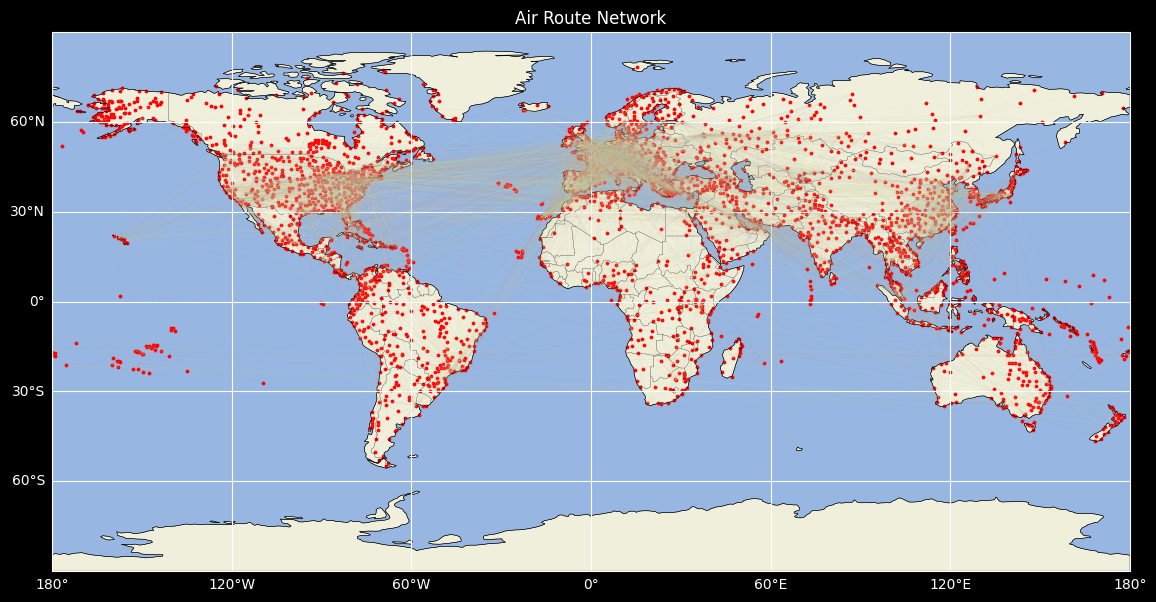

In [15]:
plt.figure(figsize=(14, 7))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND, edgecolor="black", linewidth=0.2)
ax.add_feature(cfeature.COASTLINE, linewidth=0.4)
ax.add_feature(cfeature.BORDERS, linewidth=0.2)

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# edges
for node1, node2 in G.edges():
    lat1, lon1 = G.nodes[node1]["latitude"], G.nodes[node1]["longitude"]
    lat2, lon2 = G.nodes[node2]["latitude"], G.nodes[node2]["longitude"]
    ax.plot(
        [lon1, lon2],
        [lat1, lat2],
        transform=ccrs.PlateCarree(),
        linewidth=0.2,
        alpha=0.15
    )

# nodes
lons = [G.nodes[n]["longitude"] for n in G.nodes()]
lats = [G.nodes[n]["latitude"] for n in G.nodes()]
ax.scatter(lons, lats, transform=ccrs.PlateCarree(), s=3, color="red")

plt.title("Air Route Network")
plt.show()


#### Degree Distribution

Below is a function to compute the exact frequency of a particular degree value as a percentage.

Then, using Matplotlib, a Global Degree Distribution as a scatterplot for all degree values is generated.

In [16]:
k = 1
degrees = fn.degree_histogram(G)
degrees = degrees[1:]
degree_k = degrees[k]
degree_distribution = degree_k/G.number_of_nodes()

print(f"Degree Distribution of Degree {k}: {degree_distribution:.2f}")

Degree Distribution of Degree 1: 0.20


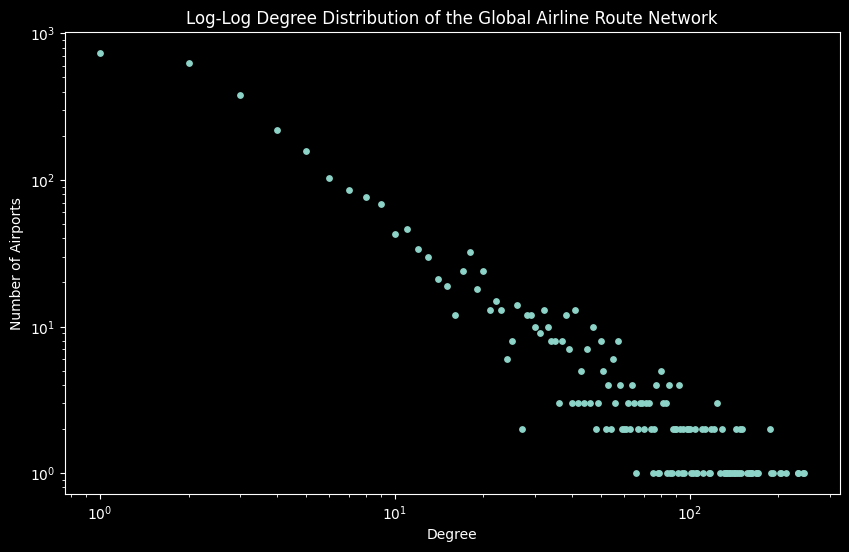

In [17]:
degree_counts = np.array(degrees)
degree_hist = np.arange(1, len(degree_counts) + 1)

mask = degree_counts > 0

plt.figure(figsize=(10, 6))
plt.scatter(degree_hist[mask], degree_counts[mask], s=15)

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Degree")
plt.ylabel("Number of Airports")
plt.title("Log-Log Degree Distribution of the Global Airline Route Network")

plt.show()


#### Node with Max Degree in Global Network

In [18]:
# Largest Degree in Global Network
target = 245

node_w_degree = [node for node, degree in G.degree() if degree == target]

print(f"Nodes with degree {target}: {node_w_degree}")

Nodes with degree 245: ['AMS']


#### Nodes per Continent

In [19]:
continents = nx.get_node_attributes(G, "continent")

count = 0
for airport in continents.values():
    if airport == "Asia":
        count+=1

print(f"Number of Airports in Asia: {count}")

count = 0
for airport in continents.values():
    if airport == "Europe":
        count+=1

print(f"Number of Airports in Europe: {count}")

count = 0
for airport in continents.values():
    if airport == "Africa":
        count+=1

print(f"Number of Airports in Africa: {count}")

count = 0
for airport in continents.values():
    if airport == "North America":
        count+=1

print(f"Number of Airports in North America: {count}")

count = 0
for airport in continents.values():
    if airport == "South America":
        count+=1

print(f"Number of Airports in South America: {count}")

count = 0
for airport in continents.values():
    if airport == "Oceania":
        count+=1

print(f"Number of Airports in Oceania: {count}")

Number of Airports in Asia: 868
Number of Airports in Europe: 569
Number of Airports in Africa: 287
Number of Airports in North America: 895
Number of Airports in South America: 303
Number of Airports in Oceania: 261


#### Subgraph of Asian Airline Routes

Generate a subgraph for the airports and routes specific to the Asian continent and isolate the largest connected component.

In [20]:
airports = list(G.nodes())
asian_airports = []

for airport in airports:
    if G.nodes[airport]["continent"] == "Asia":
        asian_airports.append(airport)

Asia = subgraph(G, asian_airports)

largest_cc_nodes = max(nx.connected_components(Asia), key=len)
Asia = Asia.subgraph(largest_cc_nodes).copy()

Asia.remove_nodes_from(list(nx.isolates(Asia)))

#### Number of Nodes and Edges

In [21]:
nodes = Asia.number_of_nodes()
edges = Asia.number_of_edges()
print(f"Number of nodes: {nodes}")
print(f"Number of edges: {edges}")

Number of nodes: 867
Number of edges: 4591


#### Asian Degree Distribution

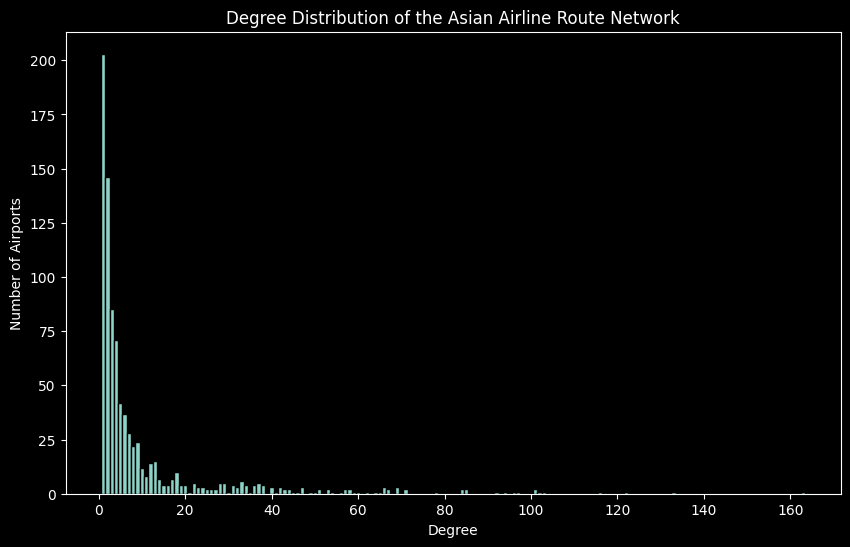

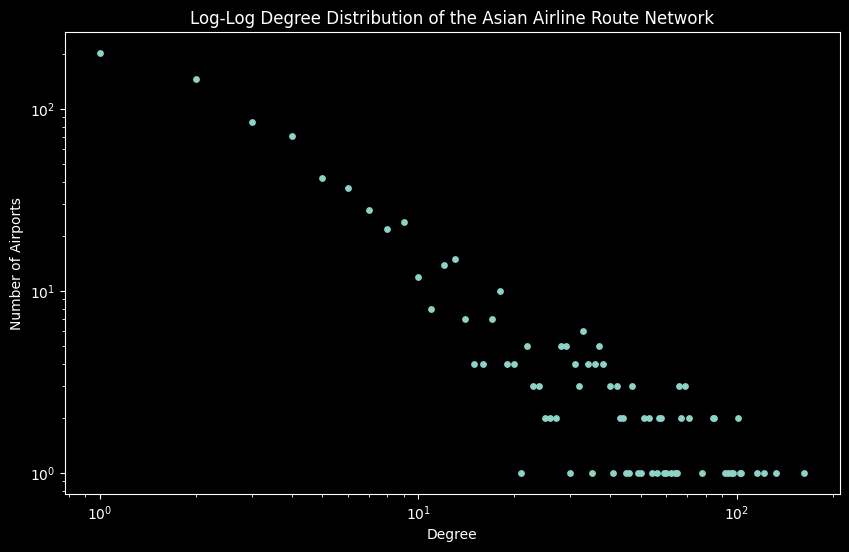

In [22]:
degrees = fn.degree_histogram(Asia)
degrees = degrees[1:]

degree_counts = np.array(degrees)
degree_hist = np.arange(1, len(degree_counts) + 1)

plt.figure(figsize=(10, 6))
plt.bar(degree_hist, degree_counts, width=1.0, edgecolor="black")

plt.xlabel("Degree")
plt.ylabel("Number of Airports")
plt.title("Degree Distribution of the Asian Airline Route Network")

plt.show()

mask = degree_counts > 0

plt.figure(figsize=(10, 6))
plt.scatter(degree_hist[mask], degree_counts[mask], s=15)

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Degree")
plt.ylabel("Number of Airports")
plt.title("Log-Log Degree Distribution of the Asian Airline Route Network")

plt.show()

#### Node with Max Degree in Asia

In [23]:
# Largest Degree in Asian Network
target = 163

node_w_degree = [node for node, degree in Asia.degree() if degree == target]

print(f"Nodes with degree {target}: {node_w_degree}")

Nodes with degree 163: ['PEK']


#### Subgraph of South American Airline Routes

Generate a subgraph for the airports and routes specific to the South American continent and isolate the largest connected component.

In [24]:
airports = list(G.nodes())
south_american_airports = []

for airport in airports:
    if G.nodes[airport]["continent"] == "South America":
        south_american_airports.append(airport)

South_America = subgraph(G, south_american_airports)

largest_cc_nodes = max(nx.connected_components(South_America), key=len)
South_America = South_America.subgraph(largest_cc_nodes).copy()

South_America.remove_nodes_from(list(nx.isolates(South_America)))

#### Number of Nodes and Edges

In [25]:
nodes = South_America.number_of_nodes()
edges = South_America.number_of_edges()
print(f"Number of nodes: {nodes}")
print(f"Number of edges: {edges}")

Number of nodes: 302
Number of edges: 736


#### South American Degree Distribution

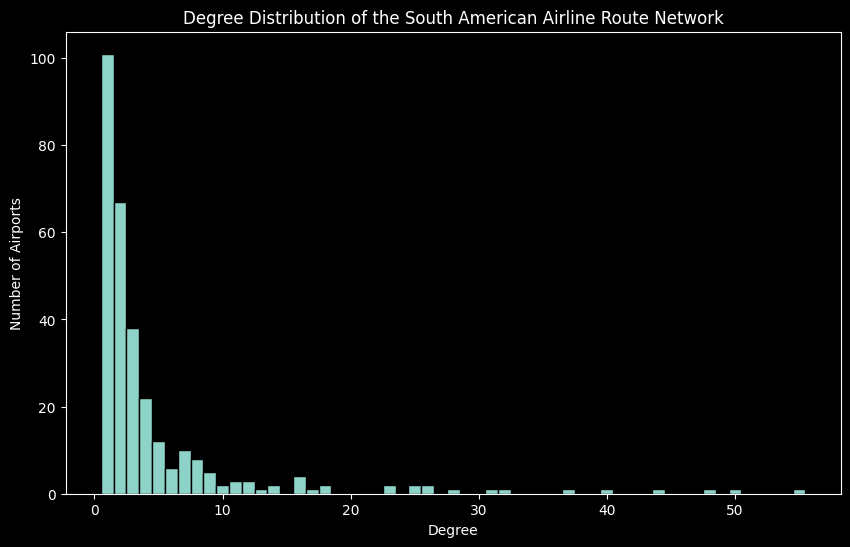

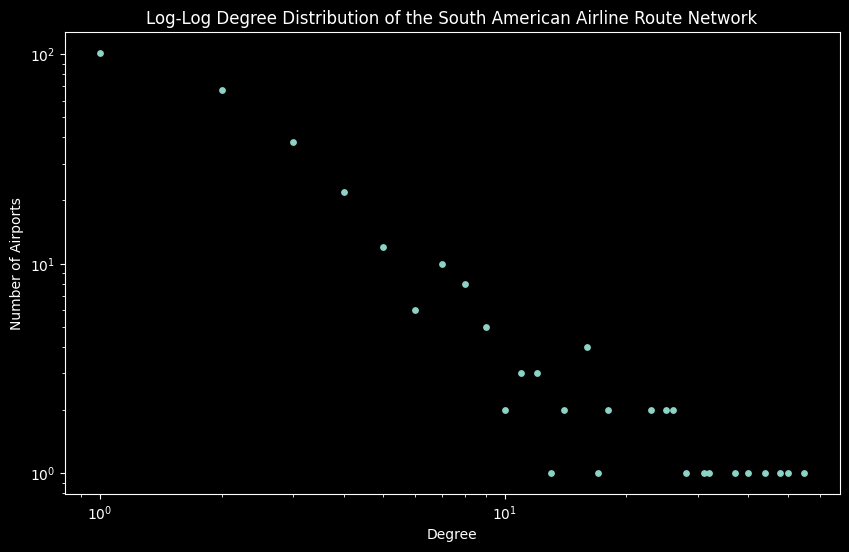

In [26]:
degrees = fn.degree_histogram(South_America)
degrees = degrees[1:]

degree_counts = np.array(degrees)
degree_hist = np.arange(1, len(degree_counts) + 1)

plt.figure(figsize=(10, 6))
plt.bar(degree_hist, degree_counts, width=1.0, edgecolor="black")

plt.xlabel("Degree")
plt.ylabel("Number of Airports")
plt.title("Degree Distribution of the South American Airline Route Network")

plt.show()

mask = degree_counts > 0

plt.figure(figsize=(10, 6))
plt.scatter(degree_hist[mask], degree_counts[mask], s=15)

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Degree")
plt.ylabel("Number of Airports")
plt.title("Log-Log Degree Distribution of the South American Airline Route Network")

plt.show()

#### Node with Largest Degree in South America

In [27]:
# Largest Degree in South American Network
target = 55

node_w_degree = [node for node, degree in South_America.degree() if degree == target]

print(f"Nodes with degree {target}: {node_w_degree}")

Nodes with degree 55: ['GRU']
